In [2]:
import numpy as np
from skimage.io import imread, imsave
import cv2
import os
import random
from glob import glob
import matplotlib.pyplot as plt
from light import *
from utils import *

### Load original image and .obj file

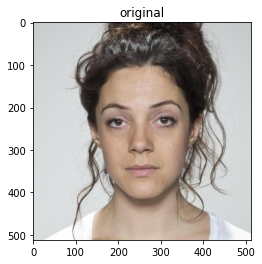

Vertices:  (38365, 3)
Colors:  (38365, 3)
Triangles:  (76073, 3)


In [3]:
# original image
image_path = "./data/image/1.jpg"

# 3D .obj file from 3DFFA_v2
objFilePath = './data/3d_obj/1_obj.obj'

image = imread(image_path)
image = image / 255
h, w, c = image.shape
plt.imshow(image)
plt.title("original")
plt.show()

with open(objFilePath) as file:
    points = []
    faces = []
    colors = []
    while 1:
        line = file.readline()
        if not line:
            break
        strs = line.split(" ")
        if strs[0] == "v":
            points.append((float(strs[1]), float(strs[2]), float(strs[3])))
            colors.append((float(strs[4]), float(strs[5]), float(strs[6])))
        if strs[0] == "f":
            faces.append((int(strs[3]), int(strs[2]), int(strs[1])))
         
points = np.array(points)
points[:, 1] = h - 1 - points[:, 1]
faces = np.array(faces) - 1
colors = np.array(colors)

print("Vertices: ", points.shape)
print("Colors: ", colors.shape)
print("Triangles: ", faces.shape)

### Get face mask & normal map and fill the normal map

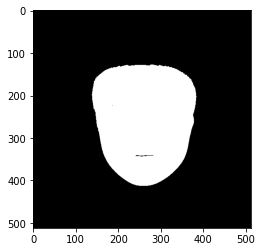

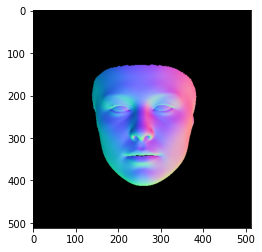

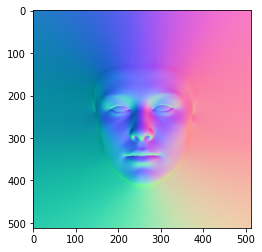

In [4]:
normal = get_normal(points, faces)
normal = (normal + 1) / 2

vis_colors = np.ones((points.shape[0], 1))
face_mask = render_texture(points.T, vis_colors.T, faces.T, h, w, c=1)
face_mask = np.squeeze(face_mask > 0).astype(np.float32)
# np.save(r"./data/mask.npy", face_mask.astype(np.bool))

normal_render = render_texture(points.T, normal.T, faces.T, h, w, c=3)
normal_render = normal_render * face_mask[:, :, np.newaxis] # (0, 1)

normal_image = normal_render * 255
inv_mask = 1 - face_mask
normal_image_filled = cv2.inpaint(normal_image.astype(np.uint8), inv_mask.astype(np.uint8), 30, cv2.INPAINT_TELEA)
new_normal = normal_image_filled.astype(np.float) * 2 / 255 - 1



plt.imshow(face_mask, cmap='gray')
plt.show()
plt.imshow(normal_render)
plt.show()
plt.imshow(normal_image_filled.astype(np.uint8))
plt.show()

### Add directional light to the image¶

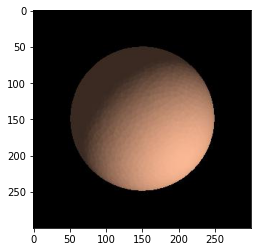

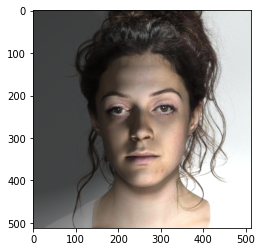

In [6]:
ambient_light = 0.3
directional_light = 1
light_direction = [1, 1, 1]

new_normal_f = np.reshape(new_normal, (-1, 3))
image_f = np.reshape(image, (-1, 3))

new_image = lighting(new_normal_f, image_f, light_direction = light_direction,
                     light_intensities = directional_light, ambient_light_intensity=ambient_light )
new_image = np.reshape(new_image, (h, w, 3))

sphere_direct_demo("./data/sphere/sphere.obj", "./data/sphere/direct_demo.jpg", light_direction, directional_light, ambient_light)
sphere_image = imread("./data/sphere/direct_demo.jpg")

plt.imshow(sphere_image)
plt.show()
plt.imshow(new_image)
plt.show()

### Add random background

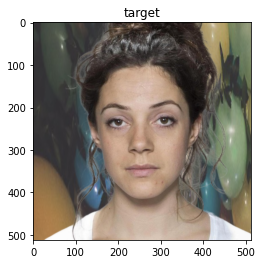

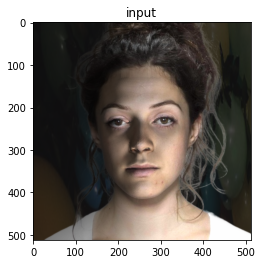

In [9]:
# folder of background images
bg_folder = "D:/project_files/graduation_project/dataset/a_datasets/background_images/"

bgs = glob(bg_folder + "*.jpg")
mask = imread("./data/human_mask/1.png")
mask = mask = (mask / 255).astype(np.float32)

bg = imread(random.choice(bgs))
bg = cv2.resize(bg, (2*bg.shape[0], 2*bg.shape[1]))
crop_h = np.random.randint(0, bg.shape[0]-513)
crop_w = np.random.randint(0, bg.shape[1]-513)
bg = bg[crop_h: crop_h+512, crop_w: crop_w+512, :]
# bg = cv2.GaussianBlur(bg, (15, 15), 3)
bg = bg.astype(np.float32) / 255
image_bg_low = bg * (1 - mask[:,:,np.newaxis]) * ambient_light + new_image * mask[:,:,np.newaxis]
image_bg_gt = bg * (1 - mask[:,:,np.newaxis]) + image * mask[:,:,np.newaxis]

plt.imshow(image_bg_gt)
plt.title("target")
plt.show()
plt.imshow(image_bg_low)
plt.title("input")
plt.show()

### sphere harmonic lighting

(9, 3)


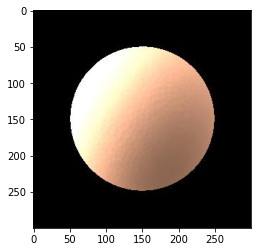

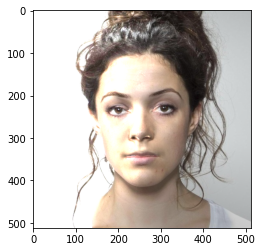

In [13]:
h = w = 512
path = "./data/sh_coeff/1.txt"
sh_coeff = np.loadtxt(path)
print(sh_coeff.shape)

new_image = add_light_sh_normal(new_normal_f, image_f, sh_coeff)
new_image = np.clip(new_image, 0, 1)
new_image = np.reshape(new_image, (h, w, 3))

sphere_sh_demo("./data/sphere/sphere.obj", "./data/sphere/sh_demo.jpg", sh_coeff)
sphere_image = imread("./data/sphere/sh_demo.jpg")

plt.imshow(sphere_image)
plt.show()
plt.imshow(new_image)
plt.show()